### 1. Загрузка данных

In [10]:
import pandas as pd
data = pd.read_csv('../Data/orange_small_churn_data.txt')
labels = pd.read_csv('../Data/orange_small_churn_labels.txt', header=None)
data['label'] = labels

In [11]:
from sklearn.cross_validation import train_test_split
data_train, data_test = train_test_split(data, test_size=0.25, random_state=42, stratify = data.label)

### 2. Работа с незаполненными значениями

Отбросим признаки, у которых больше половины значений незаполнены - их полезность сомнительна

In [12]:
bad_features = data_train.columns[data_train.isnull().mean(axis=0)>0.5]
data_train = data_train.drop(bad_features, axis=1)
print data_train.shape

(30000, 70)


Рассмотрим отдельно вещественные и категориальные признаки

In [13]:
all_real_features = ["Var"+str(i) for i in xrange(1, 191)]
real_features = data_train.columns[data_train.columns.isin(all_real_features)]
cat_features = data_train.columns[~data_train.columns.isin(all_real_features+['label'])]

В вещественных признаках заменим пропуски на средние значения признаков и произведем стандартизацию признаков

In [14]:
from sklearn.preprocessing import StandardScaler
means = data_train[real_features].mean(axis=0, skipna=True)
data_train[real_features] = data_train[real_features].fillna(means)
sc = StandardScaler()
data_train[real_features] = sc.fit_transform(data_train[real_features])

В категориальных признаках отбросим те из них, которые имеют слишком много категорий. В качестве порога выбрано 100, при этом получается приемлемое количество признаков. Иначе сильно вероятно переобучение, учитывая размер выборки в 30000.

In [15]:
import numpy as np
num_cat = np.array([np.unique(data[feat]).shape[0] for feat in cat_features])
bad_cat_features = cat_features[num_cat>100]
data_train = data_train.drop(bad_cat_features, axis=1)
cat_features = cat_features[~cat_features.isin(bad_cat_features)]

В категориальных признаках произведем dummy кодирование, при этом пропуск будем расценивать как еще одну категорию

In [16]:
data_train = pd.get_dummies(data_train, dummy_na=True, columns = cat_features, drop_first=True)
print data_train.shape

(30000, 437)


### 3. Обучение моделей и анализ результатов

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold

Оценим значение метрики PR AUC для трех моделей по кросс-валидации с 5 фолдами со стратификацией. PR AUC в sklearn называется average_precision_score.

In [18]:
from sklearn.metrics import average_precision_score, make_scorer
scorer = make_scorer(average_precision_score, needs_threshold=True)

models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
X = data_train.drop('label', axis=1)
#X = data_train[real_features]
y = data_train.label
scores = []
for model in models:
    score = cross_val_score(model, X, y, scoring=scorer, cv=StratifiedKFold(y, n_folds=5))
    scores.append(score)

In [20]:
print "Scores \n Logistic regression: {} \n Random forest: {} \n Gradient boosting classifier: {}".format(*np.array(scores).mean(axis=1))
#np.array(scores).mean(axis=1)

Scores 
 Logistic regression: 0.155974041171 
 Random forest: 0.114345996619 
 Gradient boosting classifier: 0.197626608424


Качество получилось низкое. Попробуем разобраться с помощью вспомогательной метрики. Возьмем метрику ROC AUC и сравним ее значение с PR AUC для лучшей модели.

In [21]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
gb = GradientBoostingClassifier()
gb.fit(X, y)
pr_auc = average_precision_score(y, gb.predict_proba(X)[:, 1])
roc_auc = roc_auc_score(y, gb.predict_proba(X)[:, 1])
print "PR AUC: {:.2f}".format(pr_auc)
print "ROC AUC: {:.2f}".format(roc_auc)

PR AUC: 0.31
ROC AUC: 0.79


Разница существенная, посмотрим на сами кривые.

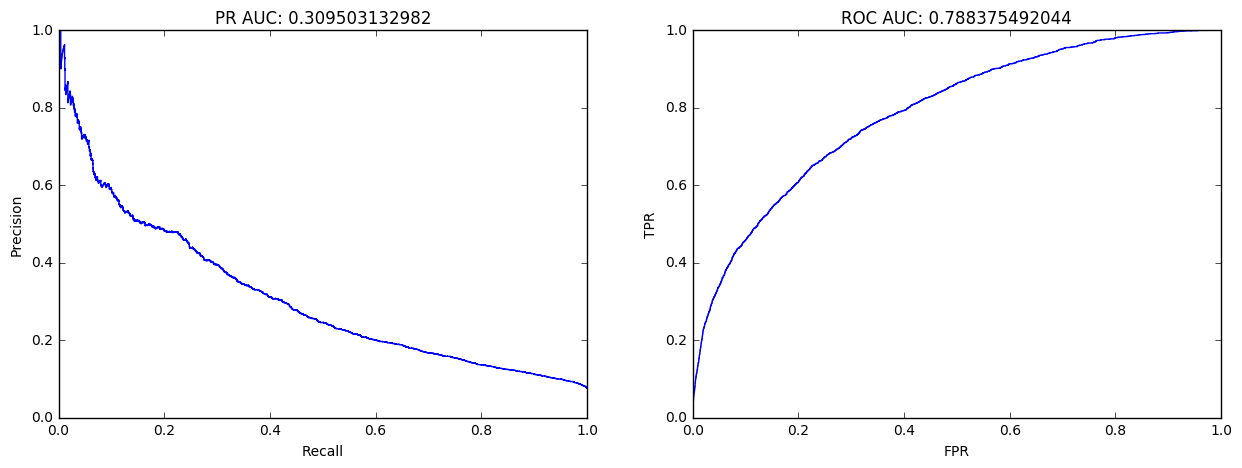

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
prs, rcs, ths = precision_recall_curve(y, gb.predict_proba(X)[:, 1])
axes[0].step(rcs, prs)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('PR AUC: {}'.format(pr_auc))

fprs, tprs, thrs = roc_curve(y, gb.predict_proba(X)[:, 1])
axes[1].step(fprs, tprs)
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('ROC AUC: {}'.format(roc_auc))

ROC AUC сильно зависит от сбалансированности классов. С ростом TPR (он же Recall) растет число ошибок FP, но из-за того, что TN очень велико (FPR = FP/(FP+TN)), FPR растет медленно. Поэтому в данном случае ROC AUC приукрашивает ситуацию, PR AUC кажется более реалистичной метрикой.

Вывод: простые baseline методы показали в данном случае достаточно низкое качество.